In [31]:
import pandas as pd
import numpy as np
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import *
# 核心模型使用第三方库
from catboost import CatBoostClassifier
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge
import lightgbm as lgb
# 交叉验证所使用的第三方库
from sklearn.model_selection import StratifiedKFold, KFold
# 评估指标所使用的的第三方库
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
# 忽略报警所使用的第三方库
import warnings
warnings.filterwarnings('ignore')
import mvtpy

In [32]:
data_2 = pd.read_csv("t2.csv")
data_1 = pd.read_csv("t1.csv")

In [33]:
def get_dig(str):
    return str[:2]
# data_2 = pd.read_csv("t2.csv")

#data_2【17】【19】
data_2['文物编号'] = data_2['文物采样点'].apply(get_dig)

data_2['文物编号'] = data_2['文物编号'].astype(int)

data_2 = pd.merge(data_2,data_1[['文物编号','类型','表面风化']], how='left', on='文物编号')


In [43]:
data_2

,二氧化硅(SiO2),氧化钠(Na2O),氧化钾(K2O),氧化钙(CaO),氧化镁(MgO),氧化铝(Al2O3),氧化铁(Fe2O3),氧化铜(CuO),氧化铅(PbO),氧化钡(BaO),五氧化二磷(P2O5),氧化锶(SrO),氧化锡(SnO2),二氧化硫(SO2),表面风化
0,69.33,0.00,9.99,6.32,0.87,3.93,1.74,3.87,0.00,0.00,1.17,0.00,0.0,0.39,0
1,36.28,0.00,1.05,2.34,1.18,5.73,1.86,0.26,47.43,0.00,3.57,0.19,0.0,0.00,1
2,87.05,0.00,5.19,2.01,0.00,4.06,0.00,0.78,0.25,0.00,0.66,0.00,0.0,0.00,0
3,61.71,0.00,12.37,5.87,1.11,5.50,2.16,5.09,1.41,2.86,0.70,0.10,0.0,0.00,0
4,65.88,0.00,9.67,7.12,1.56,6.44,2.06,2.18,0.00,0.00,0.79,0.00,0.0,0.36,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,17.11,0.00,0.00,0.00,1.11,3.65,0.00,1.34,58.46,0.00,14.13,1.12,0.0,0.00,1
65,49.01,2.71,0.00,1.13,0.00,1.45,0.00,0.86,32.92,7.95,0.35,0.00,0.0,0.00,0
66,29.15,0.00,0.00,1.21,0.00,1.85,0.00,0.79,41.25,15.45,2.54,0.00,0.0,0.00,1
67,25.42,0.00,0.00,1.31,0.00,2.18,0.00,1.16,45.10,17.30,0.00,0.00,0.0,0.00,1


In [35]:
data_2 = data_2.fillna(0)

In [36]:
data_2

,文物采样点,二氧化硅(SiO2),氧化钠(Na2O),氧化钾(K2O),氧化钙(CaO),氧化镁(MgO),氧化铝(Al2O3),氧化铁(Fe2O3),氧化铜(CuO),氧化铅(PbO),氧化钡(BaO),五氧化二磷(P2O5),氧化锶(SrO),氧化锡(SnO2),二氧化硫(SO2),文物编号,类型,表面风化
0,01,69.33,0.00,9.99,6.32,0.87,3.93,1.74,3.87,0.00,0.00,1.17,0.00,0.0,0.39,1,高钾,无风化
1,02,36.28,0.00,1.05,2.34,1.18,5.73,1.86,0.26,47.43,0.00,3.57,0.19,0.0,0.00,2,铅钡,风化
2,03部位1,87.05,0.00,5.19,2.01,0.00,4.06,0.00,0.78,0.25,0.00,0.66,0.00,0.0,0.00,3,高钾,无风化
3,03部位2,61.71,0.00,12.37,5.87,1.11,5.50,2.16,5.09,1.41,2.86,0.70,0.10,0.0,0.00,3,高钾,无风化
4,04,65.88,0.00,9.67,7.12,1.56,6.44,2.06,2.18,0.00,0.00,0.79,0.00,0.0,0.36,4,高钾,无风化
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,54严重风化点,17.11,0.00,0.00,0.00,1.11,3.65,0.00,1.34,58.46,0.00,14.13,1.12,0.0,0.00,54,铅钡,风化
65,55,49.01,2.71,0.00,1.13,0.00,1.45,0.00,0.86,32.92,7.95,0.35,0.00,0.0,0.00,55,铅钡,无风化
66,56,29.15,0.00,0.00,1.21,0.00,1.85,0.00,0.79,41.25,15.45,2.54,0.00,0.0,0.00,56,铅钡,风化
67,57,25.42,0.00,0.00,1.31,0.00,2.18,0.00,1.16,45.10,17.30,0.00,0.00,0.0,0.00,57,铅钡,风化


In [37]:
def label_encoder(series):
    ls = list(series.unique())
    length = len(ls)
    cat_dict = dict(zip(ls, range(length)))
    return series.map(cat_dict)


In [38]:
data_2['类型'] = label_encoder(data_2['类型'])
data_2['表面风化'] = label_encoder(data_2['表面风化'])

In [39]:
del data_2['文物采样点']
del data_2['文物编号']

In [40]:
data_2


,二氧化硅(SiO2),氧化钠(Na2O),氧化钾(K2O),氧化钙(CaO),氧化镁(MgO),氧化铝(Al2O3),氧化铁(Fe2O3),氧化铜(CuO),氧化铅(PbO),氧化钡(BaO),五氧化二磷(P2O5),氧化锶(SrO),氧化锡(SnO2),二氧化硫(SO2),类型,表面风化
0,69.33,0.00,9.99,6.32,0.87,3.93,1.74,3.87,0.00,0.00,1.17,0.00,0.0,0.39,0,0
1,36.28,0.00,1.05,2.34,1.18,5.73,1.86,0.26,47.43,0.00,3.57,0.19,0.0,0.00,1,1
2,87.05,0.00,5.19,2.01,0.00,4.06,0.00,0.78,0.25,0.00,0.66,0.00,0.0,0.00,0,0
3,61.71,0.00,12.37,5.87,1.11,5.50,2.16,5.09,1.41,2.86,0.70,0.10,0.0,0.00,0,0
4,65.88,0.00,9.67,7.12,1.56,6.44,2.06,2.18,0.00,0.00,0.79,0.00,0.0,0.36,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,17.11,0.00,0.00,0.00,1.11,3.65,0.00,1.34,58.46,0.00,14.13,1.12,0.0,0.00,1,1
65,49.01,2.71,0.00,1.13,0.00,1.45,0.00,0.86,32.92,7.95,0.35,0.00,0.0,0.00,1,0
66,29.15,0.00,0.00,1.21,0.00,1.85,0.00,0.79,41.25,15.45,2.54,0.00,0.0,0.00,1,1
67,25.42,0.00,0.00,1.31,0.00,2.18,0.00,1.16,45.10,17.30,0.00,0.00,0.0,0.00,1,1


In [11]:
# del data_2['类型']

In [12]:
data_2_type0 = data_2[data_2['类型']==0]
data_2_type1 = data_2[data_2['类型']==1]

In [13]:
data_2_type1

,二氧化硅(SiO2),氧化钠(Na2O),氧化钾(K2O),氧化钙(CaO),氧化镁(MgO),氧化铝(Al2O3),氧化铁(Fe2O3),氧化铜(CuO),氧化铅(PbO),氧化钡(BaO),五氧化二磷(P2O5),氧化锶(SrO),氧化锡(SnO2),二氧化硫(SO2),类型,表面风化
1,36.28,0.00,1.05,2.34,1.18,5.73,1.86,0.26,47.43,0.00,3.57,0.19,0.00,0.00,1,1
9,20.14,0.00,0.00,1.48,0.00,1.34,0.00,10.41,28.68,31.23,3.59,0.37,0.00,2.58,1,1
10,4.61,0.00,0.00,3.19,0.00,1.11,0.00,3.14,32.45,30.62,7.56,0.53,0.00,15.03,1,1
13,33.59,0.00,0.21,3.51,0.71,2.69,0.00,4.93,25.39,14.61,9.38,0.37,0.00,0.00,1,1
21,29.64,0.00,0.00,2.93,0.59,3.57,1.33,3.51,42.82,5.35,8.83,0.19,0.00,0.00,1,1
22,37.36,0.00,0.71,0.00,0.00,5.45,1.51,4.78,9.30,23.55,5.75,0.00,0.00,0.00,1,0
25,53.79,7.92,0.00,0.50,0.71,1.42,0.00,2.99,16.98,11.86,0.00,0.33,0.00,0.00,1,1
26,31.94,0.00,0.00,0.47,0.00,1.59,0.00,8.46,29.14,26.23,0.14,0.91,0.00,0.00,1,0
27,50.61,2.31,0.00,0.63,0.00,1.90,1.55,1.12,31.90,6.65,0.19,0.20,0.00,0.00,1,1
28,19.79,0.00,0.00,1.44,0.00,0.70,0.00,10.57,29.53,32.25,3.13,0.45,0.00,1.96,1,1


In [14]:
data_2_type0_f = data_2_type0[data_2_type0['表面风化']==0]
data_2_type0_uf = data_2_type0[data_2_type0['表面风化']==1]
data_2_type1_f = data_2_type1[data_2_type1['表面风化']==0]
data_2_type1_uf = data_2_type1[data_2_type1['表面风化']==1]

In [15]:
# data_2_type0 = data_2[data_2['表面风化']==0]
# data_2_type1 = data_2[data_2['表面风化']==1]

In [16]:
data_2_type0_f

,二氧化硅(SiO2),氧化钠(Na2O),氧化钾(K2O),氧化钙(CaO),氧化镁(MgO),氧化铝(Al2O3),氧化铁(Fe2O3),氧化铜(CuO),氧化铅(PbO),氧化钡(BaO),五氧化二磷(P2O5),氧化锶(SrO),氧化锡(SnO2),二氧化硫(SO2),类型,表面风化
0,69.33,0.00,9.99,6.32,0.87,3.93,1.74,3.87,0.00,0.00,1.17,0.00,0.00,0.39,0,0
2,87.05,0.00,5.19,2.01,0.00,4.06,0.00,0.78,0.25,0.00,0.66,0.00,0.00,0.00,0,0
3,61.71,0.00,12.37,5.87,1.11,5.50,2.16,5.09,1.41,2.86,0.70,0.10,0.00,0.00,0,0
4,65.88,0.00,9.67,7.12,1.56,6.44,2.06,2.18,0.00,0.00,0.79,0.00,0.00,0.36,0,0
5,61.58,0.00,10.95,7.35,1.77,7.50,2.62,3.27,0.00,0.00,0.94,0.06,0.00,0.47,0,0
6,67.65,0.00,7.37,0.00,1.98,11.15,2.39,2.51,0.20,1.38,4.18,0.11,0.00,0.00,0,0
7,59.81,0.00,7.68,5.41,1.73,10.05,6.04,2.18,0.35,0.97,4.50,0.12,0.00,0.00,0,0
15,59.01,2.86,12.53,8.70,0.00,6.16,2.88,4.73,0.00,0.00,1.27,0.00,0.00,0.00,0,0
16,62.47,3.38,12.28,8.23,0.66,9.23,0.50,0.47,1.62,0.00,0.16,0.00,0.00,0.00,0,0
17,61.87,3.21,7.44,0.00,1.02,3.15,1.04,1.29,0.19,0.00,0.26,0.00,0.00,0.00,0,0


In [17]:
del data_2_type0_f['类型']
del data_2_type0_f['表面风化']

In [18]:
from mvtpy.mvtest import mvtest
model = mvtest()

In [19]:
# del data_2_type0['表面分化']
# del data_2_type1['表面分化']

In [46]:
cols = [col for col in data_2_type0.columns]

{'Tn': 0.51, 'p-value': [0.15, 0.2]}
[0.15, 0.2]
{'Tn': 1.07, 'p-value': [0.25, 0.5]}
[0.25, 0.5]
{'Tn': 1.1, 'p-value': [0.25, 0.5]}
[0.25, 0.5]
{'Tn': 0.04, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 1.38, 'p-value': [0.25, 0.5]}
[0.25, 0.5]
{'Tn': 0.56, 'p-value': [0.25, 0.5]}
[0.25, 0.5]
{'Tn': 0.99, 'p-value': [0.25, 0.5]}
[0.25, 0.5]
{'Tn': 0.07, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 0.37, 'p-value': [0.25, 0.5]}
[0.25, 0.5]
{'Tn': 0.38, 'p-value': [0.25, 0.5]}
[0.25, 0.5]
{'Tn': 0.0, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 0.26, 'p-value': [0.15, 0.2]}
[0.15, 0.2]
{'Tn': 0.0, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 1.08, 'p-value': [0.25, 0.5]}
[0.25, 0.5]
{'Tn': 1.62, 'p-value': [0.05, 0.1]}
[0.05, 0.1]
{'Tn': 0.7, 'p-value': [0.01, 0.02]}
[0.01, 0.02]
{'Tn': 1.31, 'p-value': [0.25, 0.5]}
[0.25, 0.5]
{'Tn': 0.54, 'p-value': [0.25, 0.5]}
[0.25, 0.5]
{'Tn': 1.87, 'p-value': [0, 0.01]}
[0, 0.01]
{'Tn': 0.03, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 0.35, 'p-value': [0.25, 0.5]}
[0.25, 0.5]
{'Tn': 

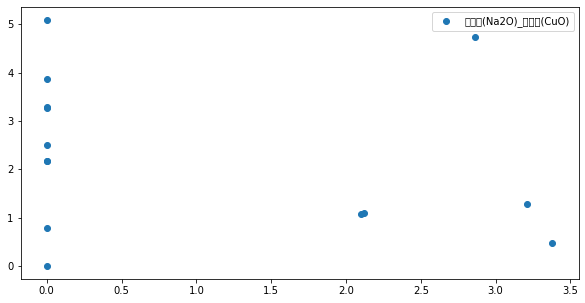

In [21]:
for i in range(14):
    for j in range(i+1,14):
        tmp = model.test(data_2_type0_f[cols[i]], data_2_type0_f[cols[j]])
        ls_tmp = model._quantiles_transformer(tmp['Tn'])
        print(tmp)
        print(ls_tmp)
        if ls_tmp[1] <= 0.01:
            plt.figure(figsize = (10,5))
#             plt.plot(data_2_type0[cols[i]],data_2_type0[cols[j]], 'ro-', color='#4169E1', alpha=0.8, linewidth=1, label=cols[i]+'_'+cols[j])
            plt.scatter(data_2_type0_f[cols[i]],data_2_type0_f[cols[j]],label = cols[i]+"_"+cols[j])
            plt.legend(loc="upper right")
#         dep_dict.append(model.test(data[cols[i]], data[cols[j]]))
        

In [51]:
data_2_type0_uf

,二氧化硅(SiO2),氧化钠(Na2O),氧化钾(K2O),氧化钙(CaO),氧化镁(MgO),氧化铝(Al2O3),氧化铁(Fe2O3),氧化铜(CuO),氧化铅(PbO),氧化钡(BaO),五氧化二磷(P2O5),氧化锶(SrO),氧化锡(SnO2),二氧化硫(SO2),类型,表面风化
8,92.63,0.0,0.00,1.07,0.00,1.98,0.17,3.24,0.0,0.0,0.61,0.0,0.0,0.0,0,1
11,95.02,0.0,0.59,0.62,0.00,1.32,0.32,1.55,0.0,0.0,0.35,0.0,0.0,0.0,0,1
12,96.77,0.0,0.92,0.21,0.00,0.81,0.26,0.84,0.0,0.0,0.00,0.0,0.0,0.0,0,1
14,94.29,0.0,1.01,0.72,0.00,1.46,0.29,1.65,0.0,0.0,0.15,0.0,0.0,0.0,0,1
24,92.35,0.0,0.74,1.66,0.64,3.50,0.35,0.55,0.0,0.0,0.21,0.0,0.0,0.0,0,1
30,92.72,0.0,0.00,0.94,0.54,2.51,0.20,1.54,0.0,0.0,0.36,0.0,0.0,0.0,0,1


In [22]:
del data_2_type0_uf['类型']
del data_2_type0_uf['表面风化']

In [23]:
for i in range(14):
    for j in range(i+1,14):
        tmp = model.test(data_2_type0_uf[cols[i]], data_2_type0_uf[cols[j]])
        ls_tmp = model._quantiles_transformer(tmp['Tn'])
        print(tmp)
        print(ls_tmp)
        if ls_tmp[1] <= 0.01:
            plt.figure(figsize = (10,5))
#             plt.plot(data_2_type1[cols[i]],data_2_type1[cols[j]], 'ro-', color='#4169E1', alpha=0.8, linewidth=1, label=cols[i]+'_'+cols[j])
            plt.scatter(data_2_type0_uf[cols[i]],data_2_type0_uf[cols[j]],label = cols[i]+"_"+cols[j])
            plt.legend(loc="upper right")
#         dep_dict.append(model.test(data[cols[i]], data[cols[j]]))
        

{'Tn': 0.0, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 0.11, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 0.47, 'p-value': [0.04, 0.05]}
[0.04, 0.05]
{'Tn': 0.0, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 0.64, 'p-value': [0.2, 0.25]}
[0.2, 0.25]
{'Tn': 0.0, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 0.33, 'p-value': [0.25, 0.5]}
[0.25, 0.5]
{'Tn': 0.0, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 0.0, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 0.0, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 0.0, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 0.0, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 0.0, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 0.0, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 0.0, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 0.0, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 0.0, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 0.0, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 0.0, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 0.0, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 0.0, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 0.0, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 0.0, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 0.0

In [25]:
data_2_type1_f

,二氧化硅(SiO2),氧化钠(Na2O),氧化钾(K2O),氧化钙(CaO),氧化镁(MgO),氧化铝(Al2O3),氧化铁(Fe2O3),氧化铜(CuO),氧化铅(PbO),氧化钡(BaO),五氧化二磷(P2O5),氧化锶(SrO),氧化锡(SnO2),二氧化硫(SO2),类型,表面风化
22,37.36,0.00,0.71,0.00,0.00,5.45,1.51,4.78,9.30,23.55,5.75,0.00,0.00,0.00,1,0
26,31.94,0.00,0.00,0.47,0.00,1.59,0.00,8.46,29.14,26.23,0.14,0.91,0.00,0.00,1,0
33,34.34,0.00,1.41,4.49,0.98,4.35,2.12,0.00,39.22,10.29,0.00,0.35,0.40,0.00,1,0
34,36.93,0.00,0.00,4.24,0.51,3.86,2.74,0.00,37.74,10.35,1.41,0.48,0.44,0.00,1,0
35,65.91,0.00,0.00,1.60,0.89,3.11,4.59,0.44,16.55,3.42,1.62,0.30,0.00,0.00,1,0
36,69.71,0.00,0.21,0.46,0.00,2.36,1.00,0.11,19.76,4.88,0.17,0.00,0.00,0.00,1,0
37,75.51,0.00,0.15,0.64,1.00,2.35,0.00,0.47,16.16,3.55,0.13,0.00,0.00,0.00,1,0
39,65.91,0.00,0.00,0.38,0.00,1.44,0.17,0.16,22.05,5.68,0.42,0.00,0.00,0.00,1,0
41,60.12,0.00,0.23,0.89,0.00,2.72,0.00,3.01,17.24,10.34,1.46,0.31,0.00,3.66,1,0
51,61.28,2.66,0.11,0.84,0.74,5.00,0.00,0.53,15.99,10.96,0.00,0.23,0.00,0.00,1,0


In [26]:
del data_2_type1_f['类型']
del data_2_type1_f['表面风化']

In [27]:
for i in range(14):
    for j in range(i+1,14):
        tmp = model.test(data_2_type1_f[cols[i]], data_2_type1_f[cols[j]])
        ls_tmp = model._quantiles_transformer(tmp['Tn'])
        print(tmp)
        print(ls_tmp)
        if ls_tmp[1] <= 0.01:
            plt.figure(figsize = (10,5))
#             plt.plot(data_2_type1[cols[i]],data_2_type1[cols[j]], 'ro-', color='#4169E1', alpha=0.8, linewidth=1, label=cols[i]+'_'+cols[j])
            plt.scatter(data_2_type1_f[cols[i]],data_2_type1_f[cols[j]],label = cols[i]+"_"+cols[j])
            plt.legend(loc="upper right")
#         dep_dict.append(model.test(data[cols[i]], data[cols[j]]))
        

{'Tn': 0.17, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 0.25, 'p-value': [0.15, 0.2]}
[0.15, 0.2]
{'Tn': 0.47, 'p-value': [0.15, 0.2]}
[0.15, 0.2]
{'Tn': 0.18, 'p-value': [0.25, 0.5]}
[0.25, 0.5]
{'Tn': 0.64, 'p-value': [0.25, 0.5]}
[0.25, 0.5]
{'Tn': 0.62, 'p-value': [0.25, 0.5]}
[0.25, 0.5]
{'Tn': 0.56, 'p-value': [0.25, 0.5]}
[0.25, 0.5]
{'Tn': 1.95, 'p-value': [0.15, 0.2]}
[0.15, 0.2]
{'Tn': 1.41, 'p-value': [0.2, 0.25]}
[0.2, 0.25]
{'Tn': 0.19, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 0.0, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 0.0, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 0.09, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 0.05, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 0.22, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 0.1, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 0.41, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 0.35, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 0.17, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 1.51, 'p-value': [0.25, 0.5]}
[0.25, 0.5]
{'Tn': 1.36, 'p-value': [0.25, 0.5]}
[0.25, 0.5]
{'Tn': 0.25, 'p-value': [0.5, 1]}
[0.5, 

In [28]:
data_2_type1_uf

,二氧化硅(SiO2),氧化钠(Na2O),氧化钾(K2O),氧化钙(CaO),氧化镁(MgO),氧化铝(Al2O3),氧化铁(Fe2O3),氧化铜(CuO),氧化铅(PbO),氧化钡(BaO),五氧化二磷(P2O5),氧化锶(SrO),氧化锡(SnO2),二氧化硫(SO2),类型,表面风化
1,36.28,0.00,1.05,2.34,1.18,5.73,1.86,0.26,47.43,0.00,3.57,0.19,0.00,0.00,1,1
9,20.14,0.00,0.00,1.48,0.00,1.34,0.00,10.41,28.68,31.23,3.59,0.37,0.00,2.58,1,1
10,4.61,0.00,0.00,3.19,0.00,1.11,0.00,3.14,32.45,30.62,7.56,0.53,0.00,15.03,1,1
13,33.59,0.00,0.21,3.51,0.71,2.69,0.00,4.93,25.39,14.61,9.38,0.37,0.00,0.00,1,1
21,29.64,0.00,0.00,2.93,0.59,3.57,1.33,3.51,42.82,5.35,8.83,0.19,0.00,0.00,1,1
25,53.79,7.92,0.00,0.50,0.71,1.42,0.00,2.99,16.98,11.86,0.00,0.33,0.00,0.00,1,1
27,50.61,2.31,0.00,0.63,0.00,1.90,1.55,1.12,31.90,6.65,0.19,0.20,0.00,0.00,1,1
28,19.79,0.00,0.00,1.44,0.00,0.70,0.00,10.57,29.53,32.25,3.13,0.45,0.00,1.96,1,1
29,3.72,0.00,0.40,3.01,0.00,1.18,0.00,3.60,29.92,35.45,6.04,0.62,0.00,15.95,1,1
31,68.08,0.00,0.26,1.34,1.00,4.70,0.41,0.33,17.14,4.04,1.04,0.12,0.23,0.00,1,1


In [29]:
del data_2_type1_uf['类型']
del data_2_type1_uf['表面风化']

{'Tn': 1.58, 'p-value': [0.02, 0.03]}
[0.02, 0.03]
{'Tn': 0.11, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 1.92, 'p-value': [0.02, 0.03]}
[0.02, 0.03]
{'Tn': 0.63, 'p-value': [0.05, 0.1]}
[0.05, 0.1]
{'Tn': 1.99, 'p-value': [0.1, 0.15]}
[0.1, 0.15]
{'Tn': 0.16, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 1.78, 'p-value': [0.03, 0.04]}
[0.03, 0.04]
{'Tn': 5.56, 'p-value': [0, 0.01]}
[0, 0.01]
{'Tn': 3.19, 'p-value': [0, 0.01]}
[0, 0.01]
{'Tn': 2.33, 'p-value': [0.05, 0.1]}
[0.05, 0.1]
{'Tn': 0.23, 'p-value': [0.2, 0.25]}
[0.2, 0.25]
{'Tn': 0.19, 'p-value': [0.25, 0.5]}
[0.25, 0.5]
{'Tn': 1.01, 'p-value': [0.04, 0.05]}
[0.04, 0.05]
{'Tn': 0.08, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 3.57, 'p-value': [0, 0.01]}
[0, 0.01]
{'Tn': 0.16, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 1.92, 'p-value': [0.15, 0.2]}
[0.15, 0.2]
{'Tn': 0.14, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 2.32, 'p-value': [0, 0.01]}
[0, 0.01]
{'Tn': 5.74, 'p-value': [0, 0.01]}
[0, 0.01]
{'Tn': 3.21, 'p-value': [0, 0.01]}
[0, 0.01]
{'Tn': 3.79, 'p-v

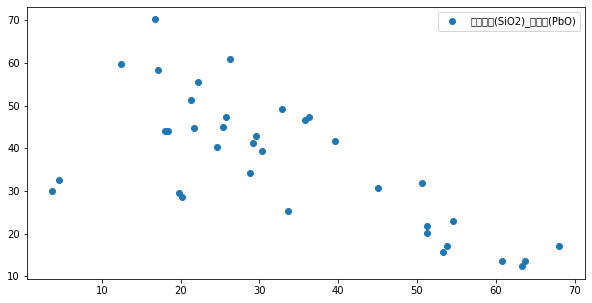

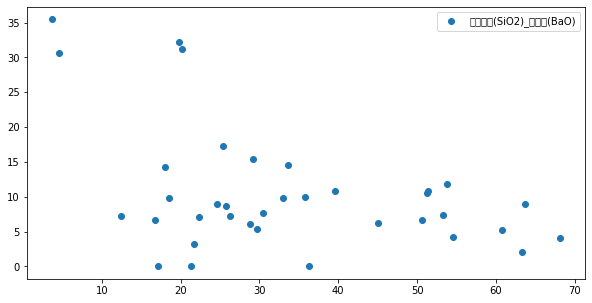

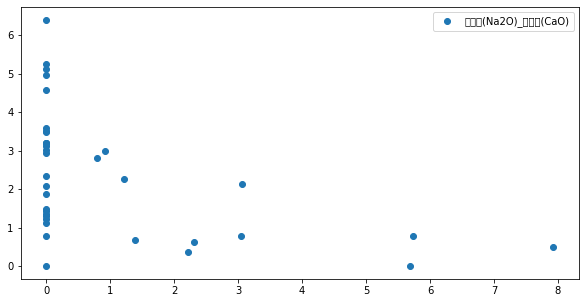

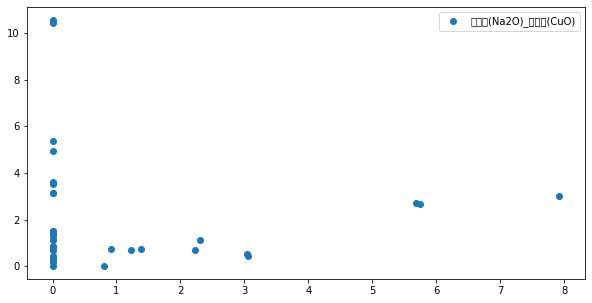

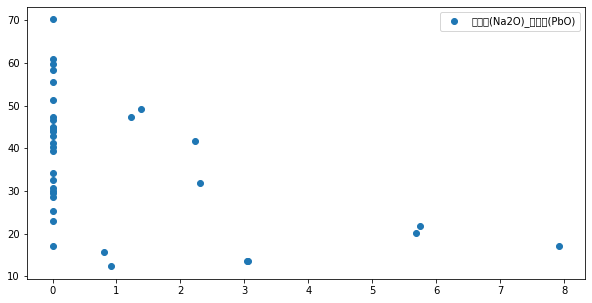

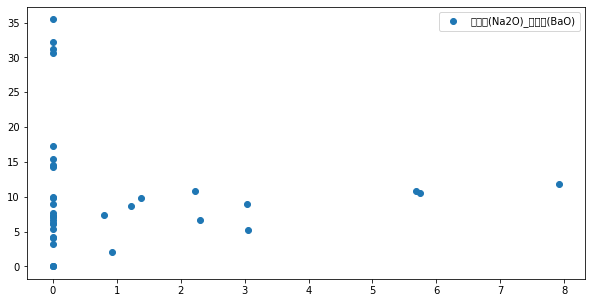

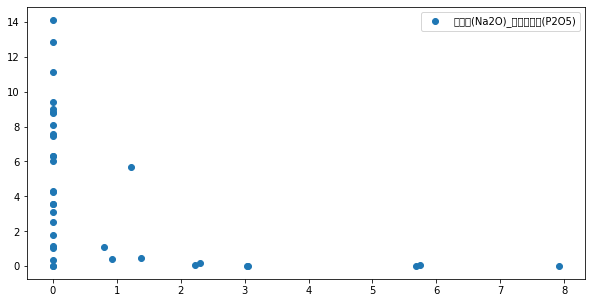

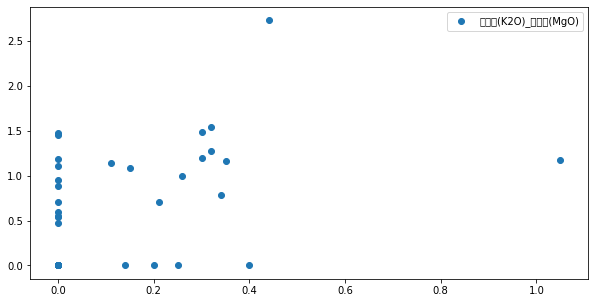

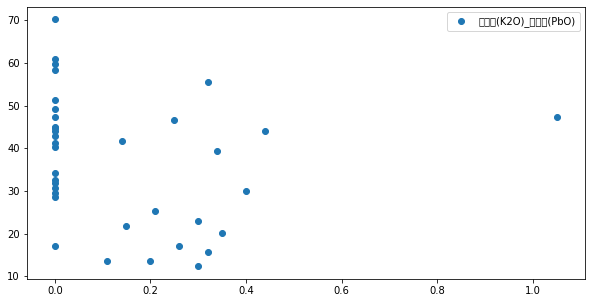

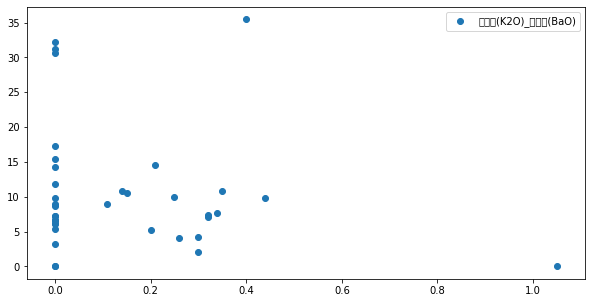

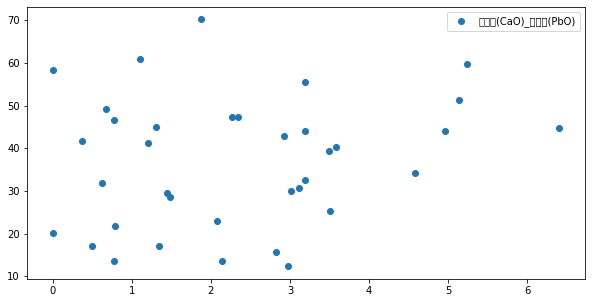

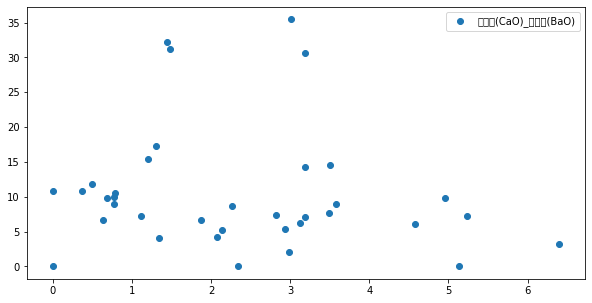

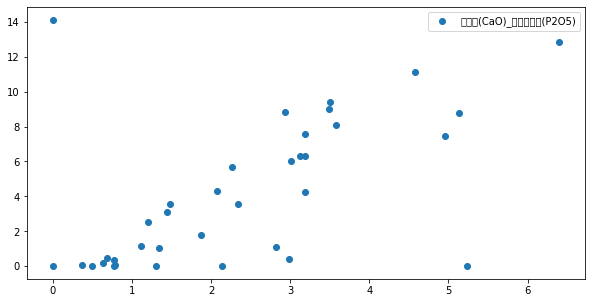

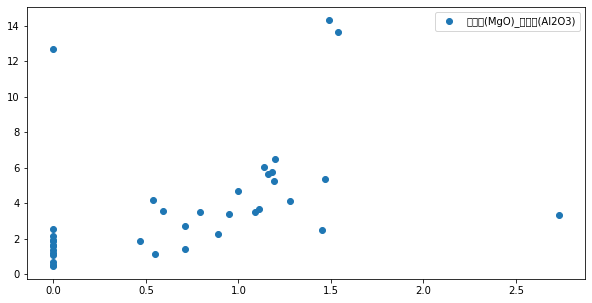

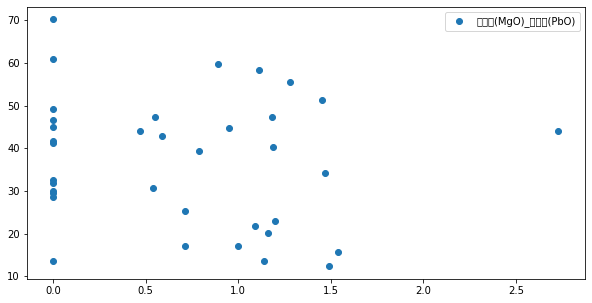

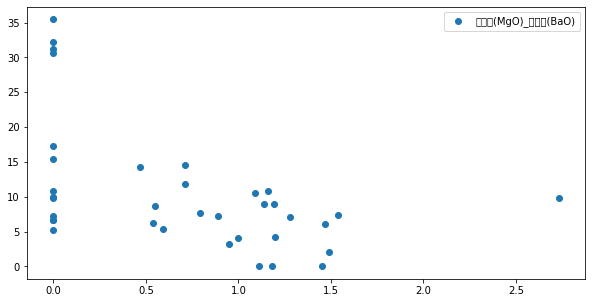

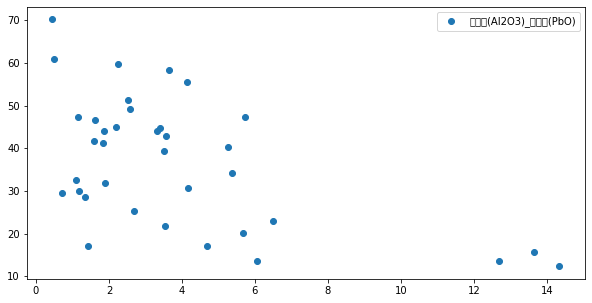

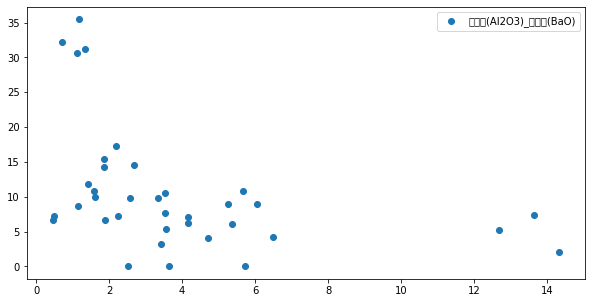

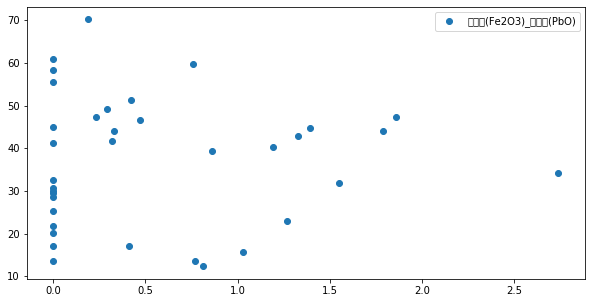

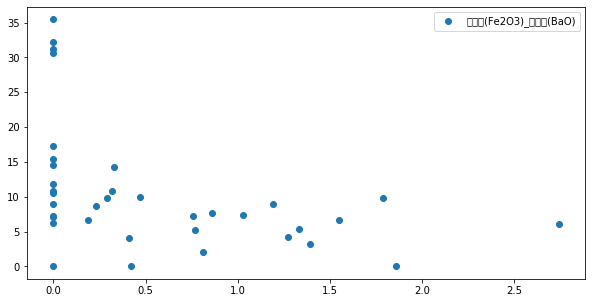

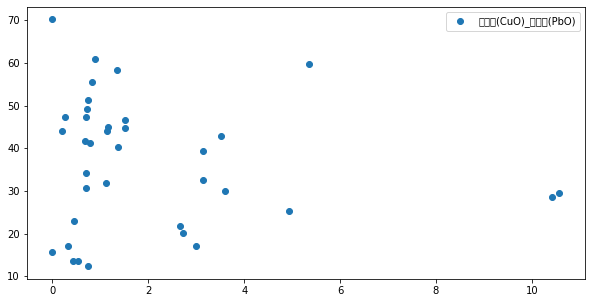

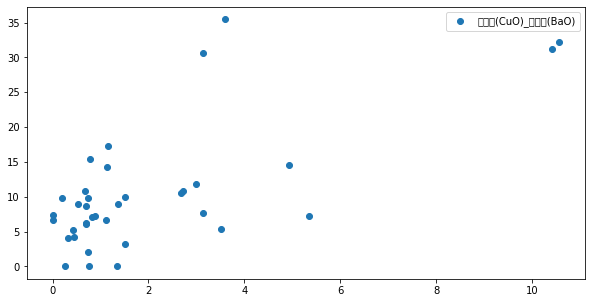

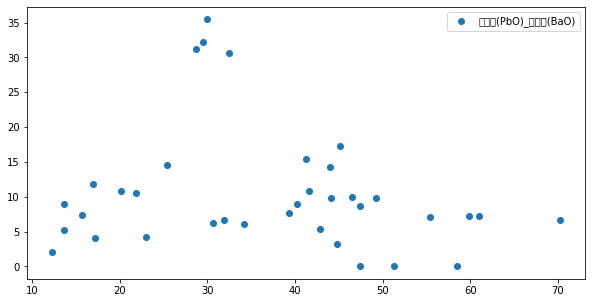

In [30]:
for i in range(14):
    for j in range(i+1,14):
        tmp = model.test(data_2_type1_uf[cols[i]], data_2_type1_uf[cols[j]])
        ls_tmp = model._quantiles_transformer(tmp['Tn'])
        print(tmp)
        print(ls_tmp)
        if ls_tmp[1] <= 0.01:
            plt.figure(figsize = (10,5))
#             plt.plot(data_2_type1[cols[i]],data_2_type1[cols[j]], 'ro-', color='#4169E1', alpha=0.8, linewidth=1, label=cols[i]+'_'+cols[j])
            plt.scatter(data_2_type1_uf[cols[i]],data_2_type1_uf[cols[j]],label = cols[i]+"_"+cols[j])
            plt.legend(loc="upper right")
            plt.savefig("D:/Desktop/数模gs/CUMCM2022Problems/C题/no4_picture/铅钡未风化/铅钡未分化_{}_{}.png".format(cols[i],cols[j]))
#         dep_dict.append(model.test(data[cols[i]], data[cols[j]]))
        

风化前

In [42]:
del data_2['类型']

KeyError: '类型'

In [44]:
data_2

,二氧化硅(SiO2),氧化钠(Na2O),氧化钾(K2O),氧化钙(CaO),氧化镁(MgO),氧化铝(Al2O3),氧化铁(Fe2O3),氧化铜(CuO),氧化铅(PbO),氧化钡(BaO),五氧化二磷(P2O5),氧化锶(SrO),氧化锡(SnO2),二氧化硫(SO2),表面风化
0,69.33,0.00,9.99,6.32,0.87,3.93,1.74,3.87,0.00,0.00,1.17,0.00,0.0,0.39,0
1,36.28,0.00,1.05,2.34,1.18,5.73,1.86,0.26,47.43,0.00,3.57,0.19,0.0,0.00,1
2,87.05,0.00,5.19,2.01,0.00,4.06,0.00,0.78,0.25,0.00,0.66,0.00,0.0,0.00,0
3,61.71,0.00,12.37,5.87,1.11,5.50,2.16,5.09,1.41,2.86,0.70,0.10,0.0,0.00,0
4,65.88,0.00,9.67,7.12,1.56,6.44,2.06,2.18,0.00,0.00,0.79,0.00,0.0,0.36,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,17.11,0.00,0.00,0.00,1.11,3.65,0.00,1.34,58.46,0.00,14.13,1.12,0.0,0.00,1
65,49.01,2.71,0.00,1.13,0.00,1.45,0.00,0.86,32.92,7.95,0.35,0.00,0.0,0.00,0
66,29.15,0.00,0.00,1.21,0.00,1.85,0.00,0.79,41.25,15.45,2.54,0.00,0.0,0.00,1
67,25.42,0.00,0.00,1.31,0.00,2.18,0.00,1.16,45.10,17.30,0.00,0.00,0.0,0.00,1


In [45]:
data_2_type0 = data_2[data_2['表面风化']==0]
data_2_type1 = data_2[data_2['表面风化']==1]

In [ ]:
from mvtpy.mvtest import mvtest
model = mvtest()

{'Tn': 0.61, 'p-value': [0.25, 0.5]}
[0.25, 0.5]
{'Tn': 1.22, 'p-value': [0.25, 0.5]}
[0.25, 0.5]
{'Tn': 1.07, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 0.3, 'p-value': [0.1, 0.15]}
[0.1, 0.15]
{'Tn': 1.31, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 0.33, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 1.05, 'p-value': [0.25, 0.5]}
[0.25, 0.5]
{'Tn': 2.65, 'p-value': [0.01, 0.02]}
[0.01, 0.02]
{'Tn': 2.51, 'p-value': [0.02, 0.03]}
[0.02, 0.03]
{'Tn': 0.39, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 0.0, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 0.29, 'p-value': [0.1, 0.15]}
[0.1, 0.15]
{'Tn': 0.11, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 1.23, 'p-value': [0.25, 0.5]}
[0.25, 0.5]
{'Tn': 1.86, 'p-value': [0.05, 0.1]}
[0.05, 0.1]
{'Tn': 0.46, 'p-value': [0.05, 0.1]}
[0.05, 0.1]
{'Tn': 1.68, 'p-value': [0.25, 0.5]}
[0.25, 0.5]
{'Tn': 0.5, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 1.8, 'p-value': [0.03, 0.04]}
[0.03, 0.04]
{'Tn': 1.62, 'p-value': [0.25, 0.5]}
[0.25, 0.5]
{'Tn': 1.83, 'p-value': [0.2, 0.25]}
[0.2, 0.25]
{'Tn': 0.51

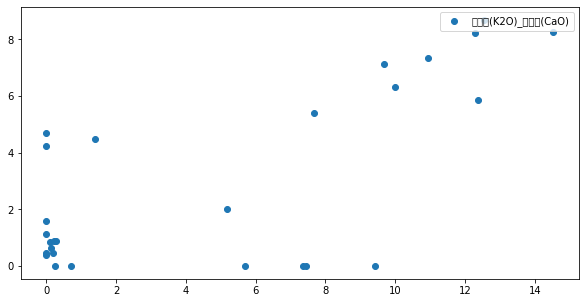

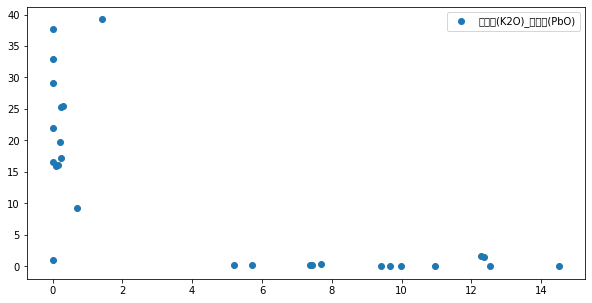

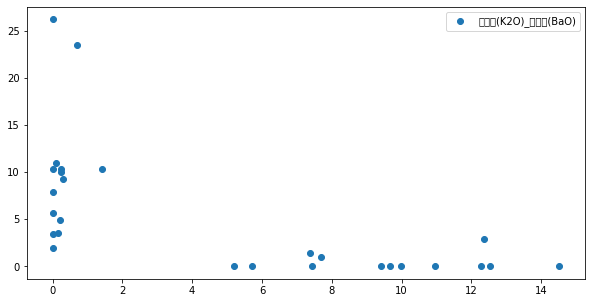

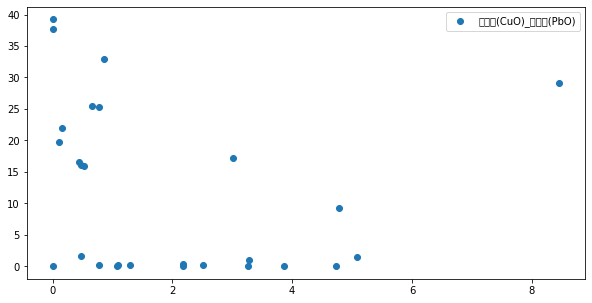

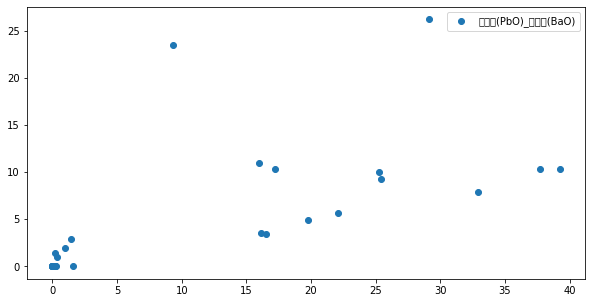

In [48]:
for i in range(14):
    for j in range(i+1,14):
        tmp = model.test(data_2_type0[cols[i]], data_2_type0[cols[j]])
        ls_tmp = model._quantiles_transformer(tmp['Tn'])
        print(tmp)
        print(ls_tmp)
        if ls_tmp[1] <= 0.01:
            plt.figure(figsize = (10,5))
#             plt.plot(data_2_type0[cols[i]],data_2_type0[cols[j]], 'ro-', color='#4169E1', alpha=0.8, linewidth=1, label=cols[i]+'_'+cols[j])
            plt.scatter(data_2_type0[cols[i]],data_2_type0[cols[j]],label = cols[i]+"_"+cols[j])
            plt.legend(loc="upper right")
            plt.savefig("D:/Desktop/数模gs/CUMCM2022Problems/C题/no4_picture/风化前/风化前_{}_{}.png".format(cols[i],cols[j]))
#         dep_dict.append(model.test(data[cols[i]], data[cols[j]]))
        

In [49]:
data_2_type1

,二氧化硅(SiO2),氧化钠(Na2O),氧化钾(K2O),氧化钙(CaO),氧化镁(MgO),氧化铝(Al2O3),氧化铁(Fe2O3),氧化铜(CuO),氧化铅(PbO),氧化钡(BaO),五氧化二磷(P2O5),氧化锶(SrO),氧化锡(SnO2),二氧化硫(SO2),表面风化
1,36.28,0.00,1.05,2.34,1.18,5.73,1.86,0.26,47.43,0.00,3.57,0.19,0.00,0.00,1
8,92.63,0.00,0.00,1.07,0.00,1.98,0.17,3.24,0.00,0.00,0.61,0.00,0.00,0.00,1
9,20.14,0.00,0.00,1.48,0.00,1.34,0.00,10.41,28.68,31.23,3.59,0.37,0.00,2.58,1
10,4.61,0.00,0.00,3.19,0.00,1.11,0.00,3.14,32.45,30.62,7.56,0.53,0.00,15.03,1
11,95.02,0.00,0.59,0.62,0.00,1.32,0.32,1.55,0.00,0.00,0.35,0.00,0.00,0.00,1
12,96.77,0.00,0.92,0.21,0.00,0.81,0.26,0.84,0.00,0.00,0.00,0.00,0.00,0.00,1
13,33.59,0.00,0.21,3.51,0.71,2.69,0.00,4.93,25.39,14.61,9.38,0.37,0.00,0.00,1
14,94.29,0.00,1.01,0.72,0.00,1.46,0.29,1.65,0.00,0.00,0.15,0.00,0.00,0.00,1
21,29.64,0.00,0.00,2.93,0.59,3.57,1.33,3.51,42.82,5.35,8.83,0.19,0.00,0.00,1
24,92.35,0.00,0.74,1.66,0.64,3.50,0.35,0.55,0.00,0.00,0.21,0.00,0.00,0.00,1


{'Tn': 1.06, 'p-value': [0.2, 0.25]}
[0.2, 0.25]
{'Tn': 0.18, 'p-value': [0.25, 0.5]}
[0.25, 0.5]
{'Tn': 2.08, 'p-value': [0.01, 0.02]}
[0.01, 0.02]
{'Tn': 0.34, 'p-value': [0.25, 0.5]}
[0.25, 0.5]
{'Tn': 1.24, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 0.19, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 1.33, 'p-value': [0.15, 0.2]}
[0.15, 0.2]
{'Tn': 6.48, 'p-value': [0, 0.01]}
[0, 0.01]
{'Tn': 3.44, 'p-value': [0, 0.01]}
[0, 0.01]
{'Tn': 2.89, 'p-value': [0, 0.01]}
[0, 0.01]
{'Tn': 0.24, 'p-value': [0.2, 0.25]}
[0.2, 0.25]
{'Tn': 0.13, 'p-value': [0.25, 0.5]}
[0.25, 0.5]
{'Tn': 1.05, 'p-value': [0.03, 0.04]}
[0.03, 0.04]
{'Tn': 0.12, 'p-value': [0.5, 1]}
[0.25, 0.5]
{'Tn': 2.64, 'p-value': [0, 0.01]}
[0, 0.01]
{'Tn': 0.27, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 2.02, 'p-value': [0.1, 0.15]}
[0.1, 0.15]
{'Tn': 0.07, 'p-value': [0.5, 1]}
[0.5, 1]
{'Tn': 2.49, 'p-value': [0, 0.01]}
[0, 0.01]
{'Tn': 6.26, 'p-value': [0, 0.01]}
[0, 0.01]
{'Tn': 3.67, 'p-value': [0, 0.01]}
[0, 0.01]
{'Tn': 2.41, 'p-value'

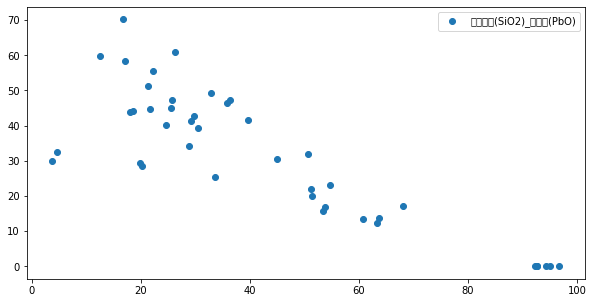

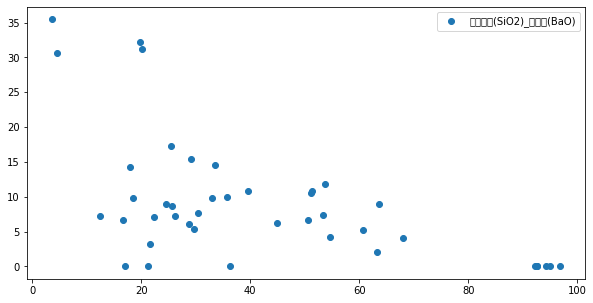

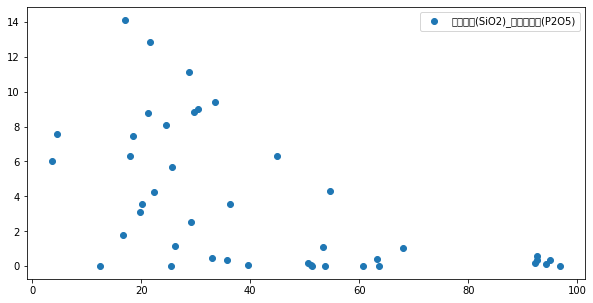

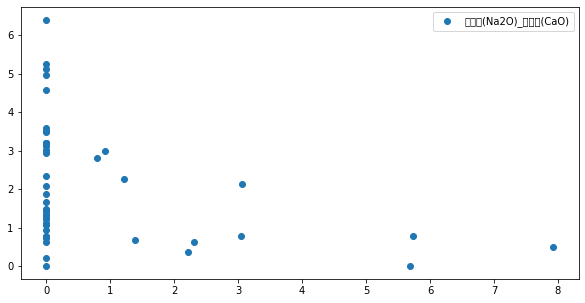

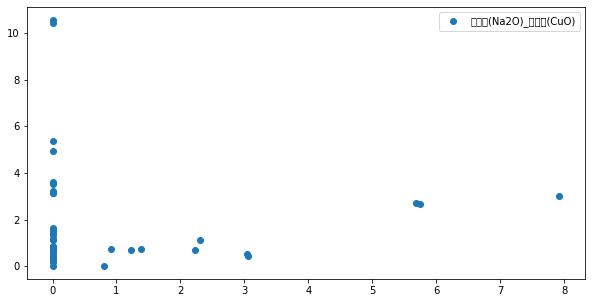

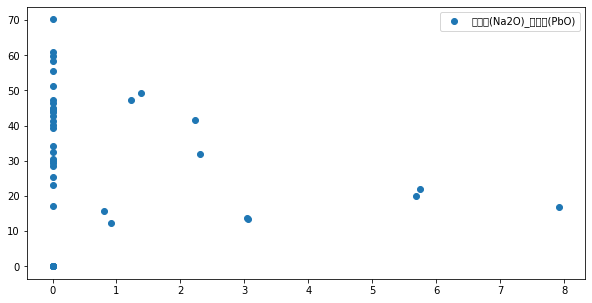

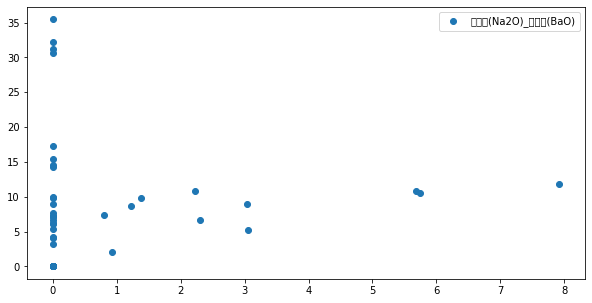

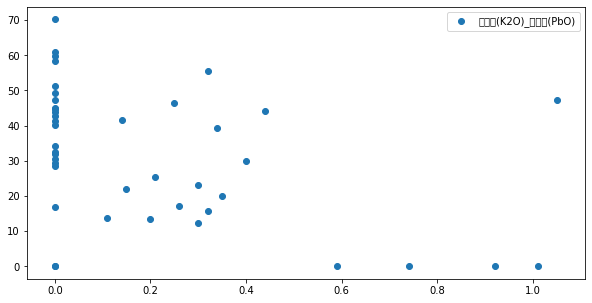

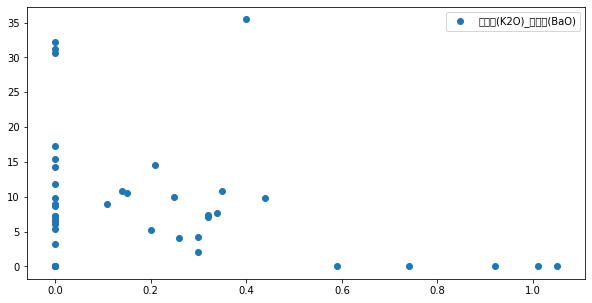

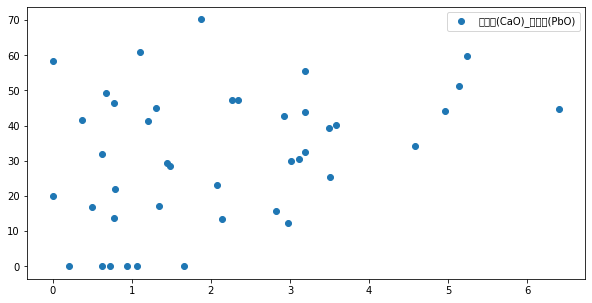

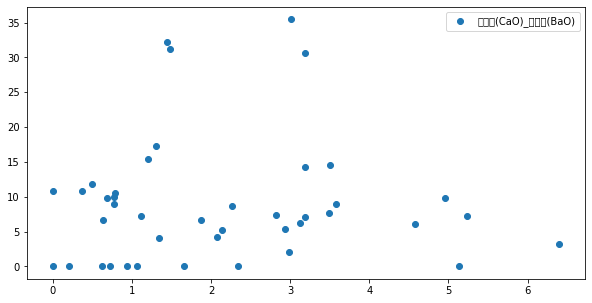

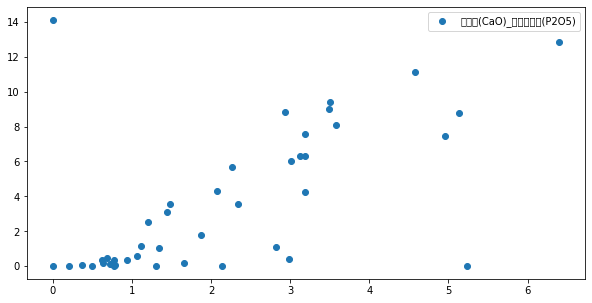

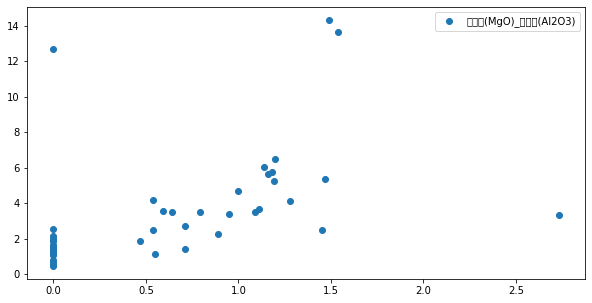

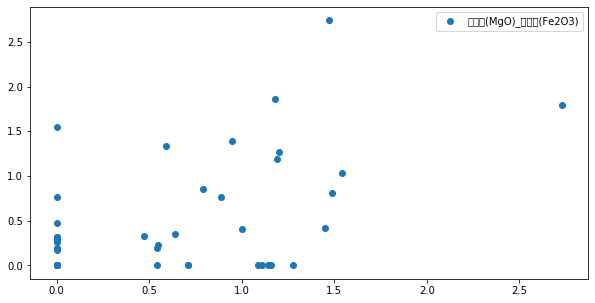

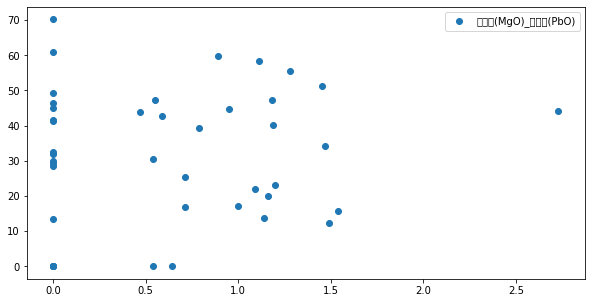

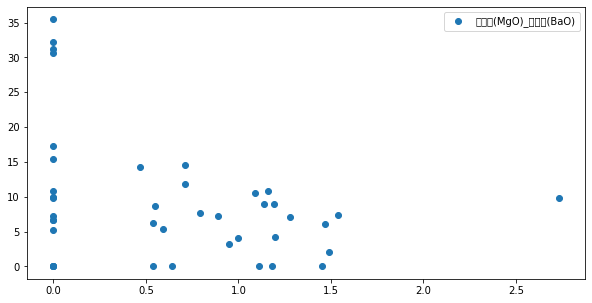

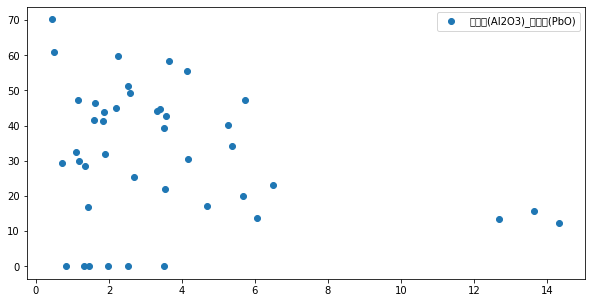

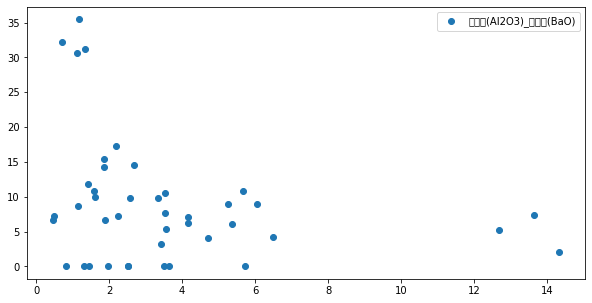

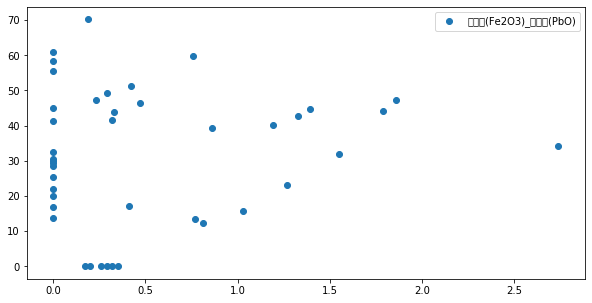

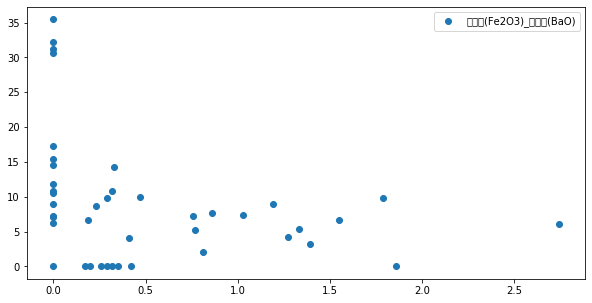

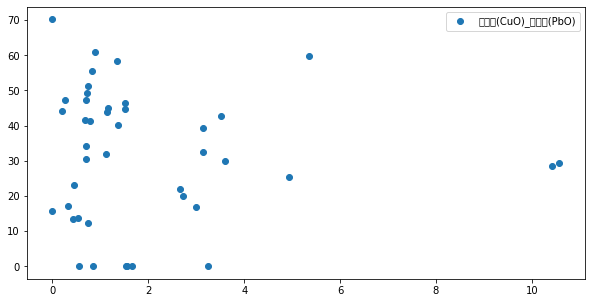

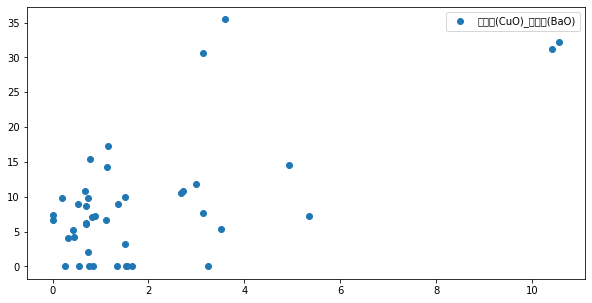

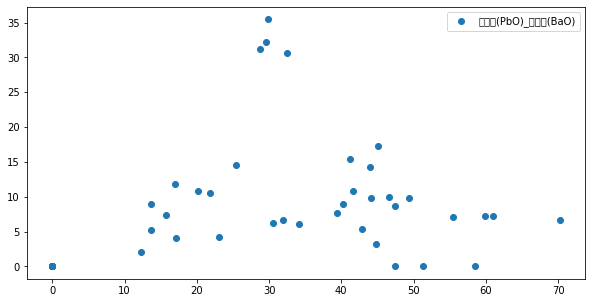

In [50]:
for i in range(14):
    for j in range(i+1,14):
        tmp = model.test(data_2_type1[cols[i]], data_2_type1[cols[j]])
        ls_tmp = model._quantiles_transformer(tmp['Tn'])
        print(tmp)
        print(ls_tmp)
        if ls_tmp[1] <= 0.01:
            plt.figure(figsize = (10,5))
#             plt.plot(data_2_type0[cols[i]],data_2_type0[cols[j]], 'ro-', color='#4169E1', alpha=0.8, linewidth=1, label=cols[i]+'_'+cols[j])
            plt.scatter(data_2_type1[cols[i]],data_2_type1[cols[j]],label = cols[i]+"_"+cols[j])
            plt.legend(loc="upper right")
            plt.savefig("D:/Desktop/数模gs/CUMCM2022Problems/C题/no4_picture/风化后/风化后_{}_{}.png".format(cols[i],cols[j]))
#         dep_dict.append(model.test(data[cols[i]], data[cols[j]]))
        